# Coin toss with optimal Strategy

This notebook is meant to answer the following question:
We play a game in which a coin is tossed N (say 100 times) and whose probability of heads is not fair but rather unknown drawn from a uniform distribution. 

Each round I let you chose a bet in which you earn 1 or lose 1 if you guess right the next toss. 

What is the optimal strategy and what is the fair price of this game?

The first part is the optimal strategy. This is simple as we need a strategy that maximises in each round the expected outcome. Thinking about the MLE we conclude that the best we can do is play the side of the coin that has come out the most times. Indeed:

Let $X_1, X_2, \dots, X_n$ be i.i.d. samples from a Bernoulli distribution with parameter $\theta \in [0, 1]$, then,
$$
P(X_i = x_i) = \theta^{x_i}(1 - \theta)^{1 - x_i}, \quad x_i \in \{0, 1\}
$$

$$\ell(\theta) = \log L(\theta) = \sum_{i=1}^{n} \left[ x_i \log \theta + (1 - x_i) \log (1 - \theta) \right]$$

To find the MLE, we differentiate the log-likelihood with respect to $\theta$:
$$
\frac{d\ell}{d\theta} = \sum_{i=1}^{n} \left[ \frac{x_i}{\theta} - \frac{1 - x_i}{1 - \theta} \right]
= \frac{1}{\theta} \sum_{i=1}^{n} x_i - \frac{1}{1 - \theta} \sum_{i=1}^{n} (1 - x_i)
$$

Set the derivative equal to zero:
$$
\frac{1}{\theta} \sum x_i - \frac{1}{1 - \theta} \left(n - \sum x_i \right) = 0
$$

Let $S = \sum_{i=1}^{n} x_i$. Then we solve:
$$
\frac{S}{\theta} = \frac{n - S}{1 - \theta}
\Rightarrow S(1 - \theta) = (n - S)\theta
\Rightarrow S - S\theta = n\theta - S\theta
$$
$$
\Rightarrow S = n\theta
\Rightarrow \hat{\theta}_{\text{MLE}} = \frac{S}{n} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$



In [69]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import scipy.stats as stats
import random
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

In [43]:
class Game:
    # Simulates a game for n players over n_rounds using the given strategies
    def simulate_game(self, n, n_rounds=100, strategies=['play_optimal']):
        ps = np.random.uniform(low=0.0, high=1.0, size=n)  # Assign random success probabilities to each player
        self.ps = ps  # Store probabilities
        played_paths = np.zeros(shape=[n, n_rounds, len(strategies)])  # Store strategies played per player per round
        realised_paths = np.zeros(shape=[n, n_rounds])  # Store actual outcomes (0 or 1) per player per round
        earnings = np.zeros(shape=[n, n_rounds])  # Initialize earnings (unused in current code)

        for i in range(n_rounds):  # Iterate over rounds
            for idx, strategy in enumerate(strategies):  # Iterate over strategies
                # Apply each strategy and store the result
                played_paths[:, i, idx] = self.compute_strategy(strategy_name=strategy,
                                                                paths=realised_paths,
                                                                n=i)
            # Sample actual outcomes from Bernoulli with player-specific probability
            realised_paths[:, i] = np.random.binomial(1, ps, n)
        self.realised_paths = realised_paths  # Store final realised paths
        self.played_paths = played_paths

    # Dynamically calls the strategy method by name
    def compute_strategy(self, strategy_name, **kwargs):
        try:
            strategy_method = getattr(self, strategy_name)  # Get strategy method
            return strategy_method(**kwargs)  # Execute strategy
        except AttributeError:
            return f"Error: Strategy '{strategy_name}' is unknown."  # Error message if method doesn't exist

    # Calculates earnings: +1 if prediction correct, -1 if incorrect
    def calc_earnings(self, strategy_index):
        strategy_outcome = self.played_paths[:, :, strategy_index]  # Get outcomes for specified strategy
        return 1 - 2 * np.abs(strategy_outcome - self.realised_paths)  # +1 if match, -1 if not

    # Optimal strategy: predict 1 if historical success rate > 0.5, else 0
    def play_optimal(self, paths, n):
        if n == 0:
            return np.ones(paths.shape[0])  # If no history, default to predicting 1
        return np.where(paths[:, :n].sum(axis=1)/n > 0.5, 1, 0)  # Predict based on average of past outcomes

    # Similar to optimal, but randomly flips some decisions
    def play_almost_optimal(self, paths, n, randomness=0.1):
        if n == 0:
            return np.ones(paths.shape[0])  # Default to 1
        optimal_strategy = np.where(paths[:, :n].sum(axis=1)/n > 0.5, 1, 0)  # Compute optimal choice
        random_changes = np.random.rand(paths.shape[0]) < randomness  # Random mask for changing decision
        return np.where(random_changes, 1 - optimal_strategy, optimal_strategy)  # Apply randomness

    # Optimal strategy based on recent lookback window
    def play_lookback_optimal(self, paths, n, lookback=5):
        if n == 0:
            return np.ones(paths.shape[0])  # Default prediction
        elif n <= lookback:
            optimal_strategy = np.where(paths[:, :n].sum(axis=1)/n > 0.5, 1, 0)
        else:
            optimal_strategy = np.where(paths[:, (n-lookback):n].sum(axis=1)/lookback > 0.5, 1, 0) 
        return optimal_strategy

    # Strategy guesses based on the last known outcome
    def play_by_guessing(self, paths, n):
        if n == 0:
            return np.ones(paths.shape[0])  # Default to 1
        return paths[:, n-1]  # Guess same as last round

    # Random strategy: purely random guess
    def play_random(self, paths, n):
        return np.random.choice([0, 1], size=paths.shape[0])

In [45]:
game = Game()
n_paths=200000
strat = ['play_optimal',
         'play_by_guessing',
         'play_random',
         'play_almost_optimal',
         'play_lookback_optimal']
game.simulate_game(n_paths, n_rounds=100, strategies=strat)

# Calculate and print earnings for each strategy
for i, strategy_name in enumerate(strat):
    earnings_strategy = game.calc_earnings(i)
    mean_earning = earnings_strategy.sum(axis=1).mean()
    std_earning = earnings_strategy.sum(axis=1).std()
    print(f"The earnings playing {strategy_name} are {mean_earning} and std is {std_earning}")

# Naive strategy: always predict 1
naive = 1 - 2 * np.abs(1 - game.realised_paths)
naive_mean = naive.sum(axis=1).mean()
print(f"The earnings using the naive strategy (always predict HEADS) are {naive_mean}")

The earnings playing play_optimal are 47.5361 and std is 31.323437180328725
The earnings playing play_by_guessing are 32.97635 and std is 31.229259368058987
The earnings playing play_random are -0.01465 and std is 9.996973810984004
The earnings playing play_almost_optimal are 38.03111 and std is 25.759085623676548
The earnings playing play_lookback_optimal are 42.17284 and std is 33.60131375905413
The earnings using the naive strategy (always predict HEADS) are 0.06874


We now start doing some analysis on the results.

So far it seems like there is an optimal strategy and that the fair value is around 47 pounds. The exact result is provided below.
TBD

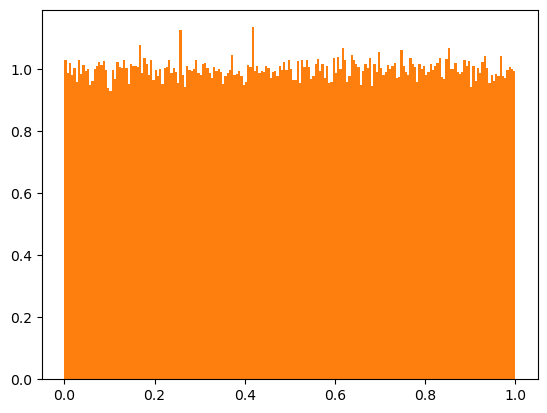

KS Statistic: 0.001514908929631742, p-value: 0.7477050272151726
Cannot reject Null Hypothesis


In [46]:
plt.hist(game.ps, bins=200, color='tab:orange', density=True)
plt.show()

ks_statistic, p_value = stats.kstest(game.ps, stats.uniform.cdf)
print(f"KS Statistic: {ks_statistic}, p-value: {p_value}")

def asses_p_value(p_value):
    if p_value>0.05:
        print('Cannot reject Null Hypothesis')
    else:
        print('Very likely can reject the null hypothesis')

asses_p_value(p_value)

In [47]:
cumulative_sum = np.cumsum(game.realised_paths, axis=1)
indices = np.arange(1, game.realised_paths.shape[1] + 1)
cumulative_mean = cumulative_sum/indices
diff=cumulative_mean - game.ps[:, np.newaxis]

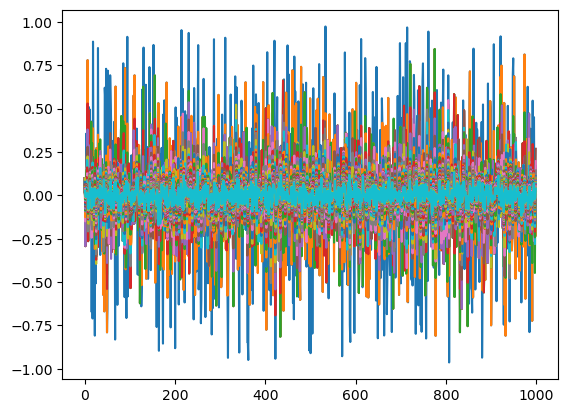

In [49]:
plt.plot(diff[:1000, :])
plt.show()

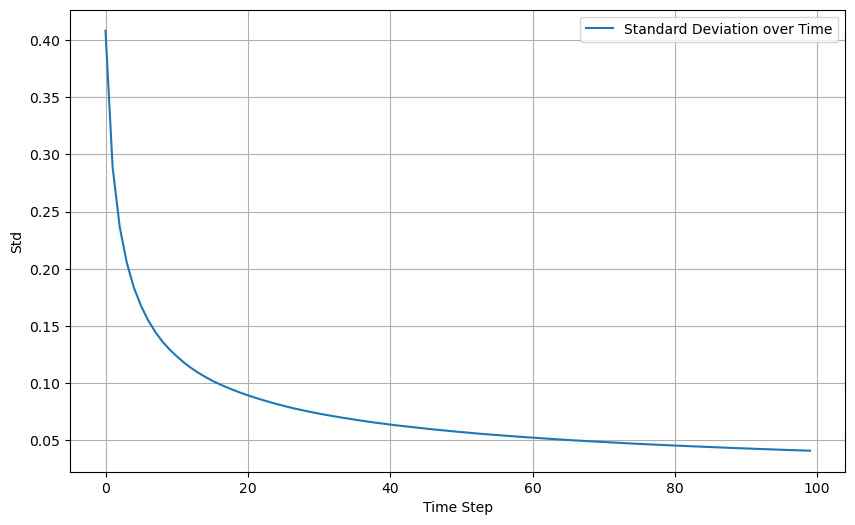

In [50]:
std_over_time = np.std(diff, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(std_over_time, label='Standard Deviation over Time')
plt.xlabel('Time Step')
plt.ylabel('Std')

plt.legend()
plt.grid(True)
plt.show()

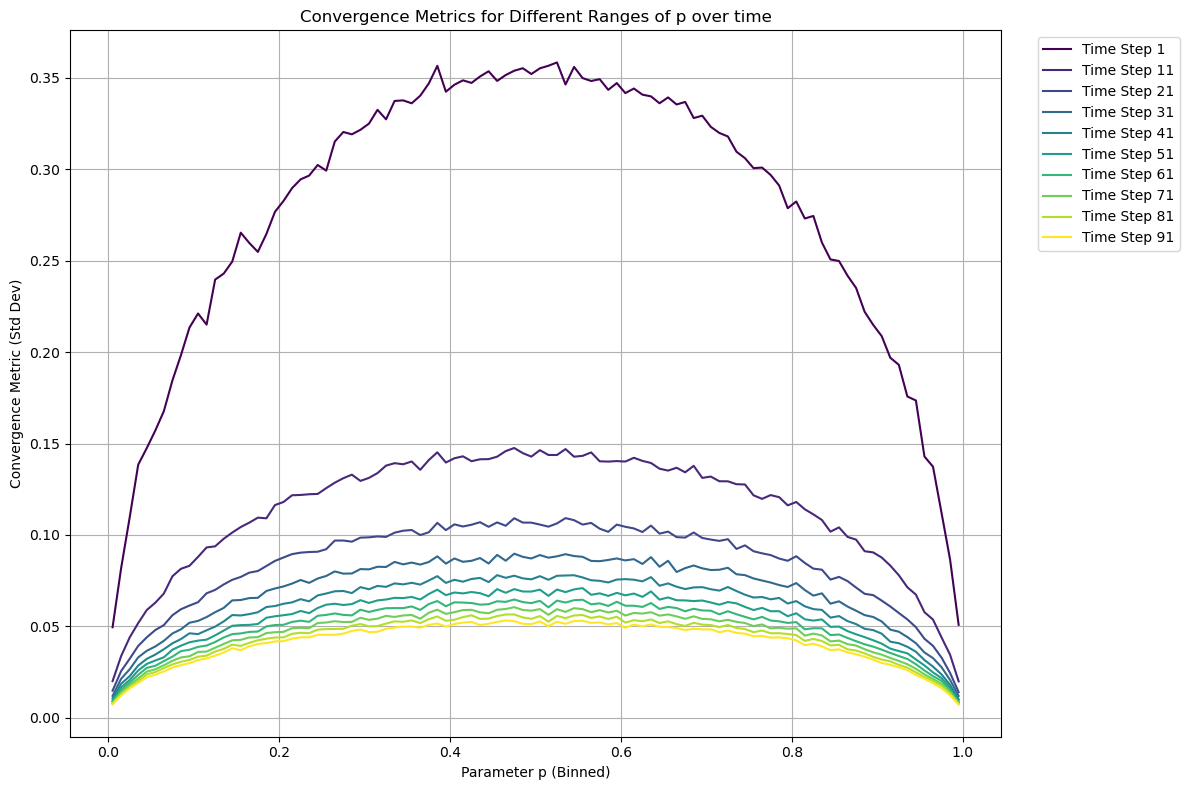

In [55]:
num_bins = 100
bins = np.linspace(0, 1, num_bins+1)
bin_indices = np.digitize(game.ps, bins) - 1

def calculate_convergence_metric_at_time(diff_group, time_step):
    std_at_time = np.std(diff_group[:, time_step])
    return std_at_time

colors = cm.viridis(np.linspace(0,1,10))
plt.figure(figsize=(12,8))
for idx, time_step in enumerate(range(1,diff.shape[1],10)):
    convergence_metrics=[ ]
    for i in range(num_bins):
        diff_group = diff[bin_indices==i]
        if diff_group.size > 0:
            convergence_metric = calculate_convergence_metric_at_time(diff_group, time_step)
            convergence_metrics.append(convergence_metric)

        else:
            convergence_metrics.append(np.nan)

    bin_centers = (bins[:-1]+bins[1:])/2
    plt.plot(bin_centers, convergence_metrics, color=colors[idx], label=f'Time Step {time_step}')
plt.xlabel('Parameter p (Binned)')
plt.ylabel('Convergence Metric (Std Dev)')
plt.title('Convergence Metrics for Different Ranges of p over time')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

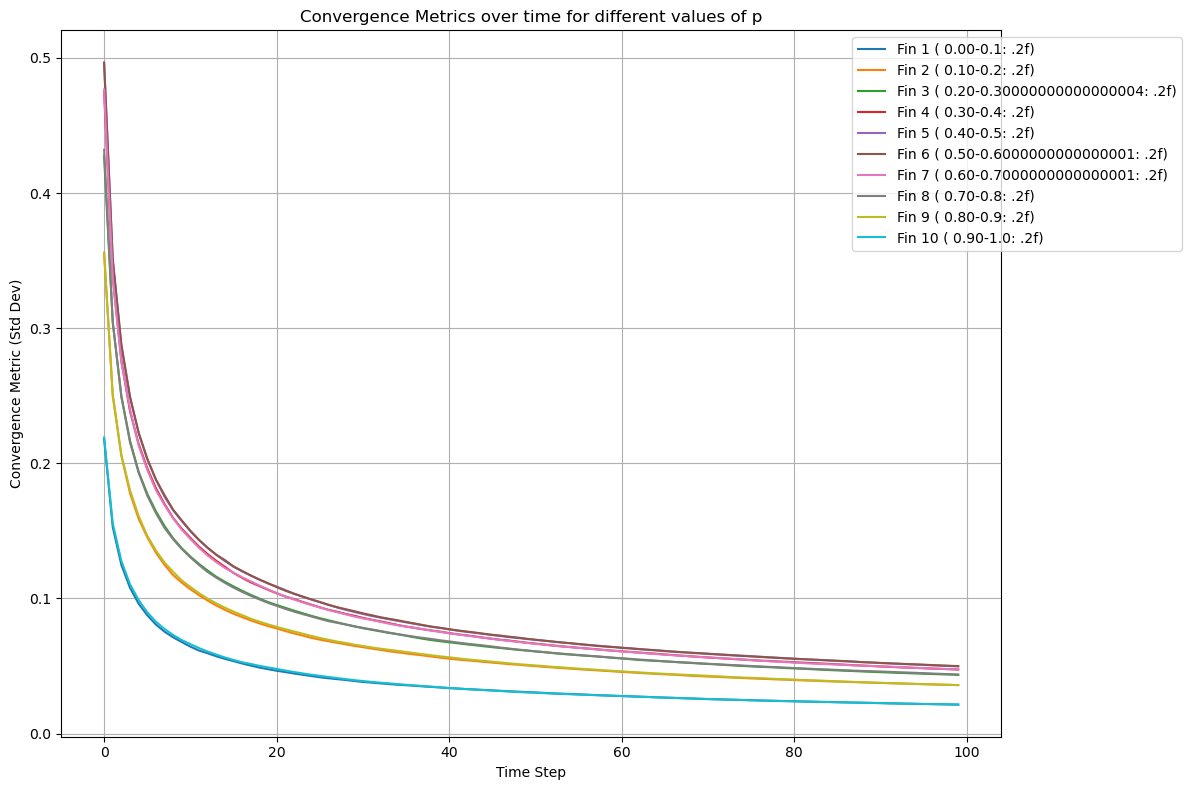

In [61]:
num_bins = 10
bins = np.linspace(0, 1, num_bins+1)
bin_indices = np.digitize(game.ps, bins) - 1
convergence_metrics_over_time = []
for i in range(num_bins):
    diff_group = diff[bin_indices==i]
    if diff_group.size > 0:
        std_over_time = np.std(diff_group, axis=0)
        convergence_metrics_over_time.append(std_over_time)
    else:
        convergence_metrics_over_time.append(np.full(diff.shape[1], np.nan))

plt.figure(figsize=(12,8))
for i, std_over_time in enumerate(convergence_metrics_over_time):
    plt.plot(std_over_time, label=f'Fin {i+1} ({bins[i]: .2f}-{bins[i+1]}: .2f)')

plt.xlabel('Time Step')
plt.ylabel('Convergence Metric (Std Dev)')
plt.title('Convergence Metrics over time for different values of p')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

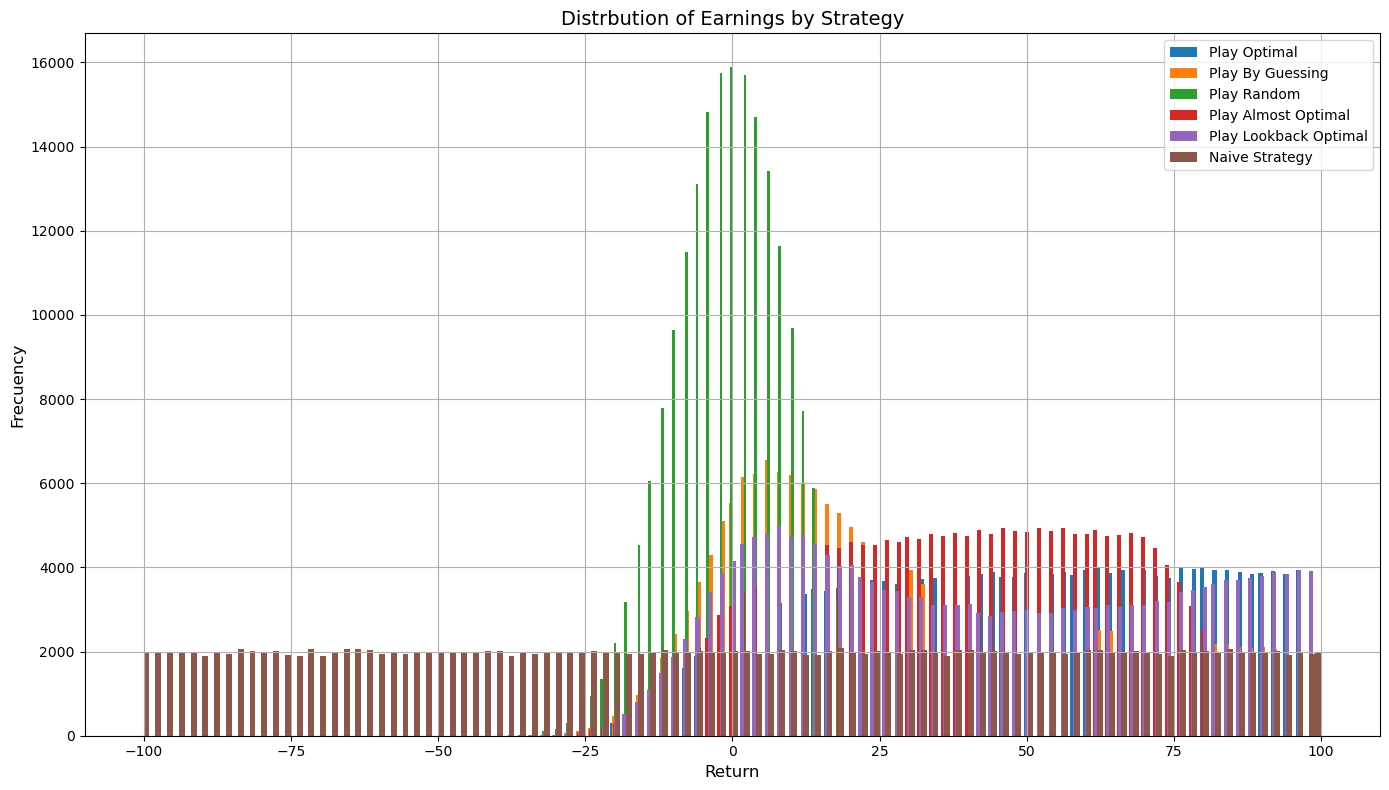

In [67]:
plt.figure(figsize=(14,8))
for idx, strategy in enumerate(strat):
    earnings = game.calc_earnings(idx)
    cumulative_earnings = earnings.sum(axis=1)
    plt.hist(cumulative_earnings, bins=200, label=strategy.replace('_', ' ').title())
plt.hist(naive.sum(axis=1), bins=200, label='Naive Strategy')
plt.title("Distrbution of Earnings by Strategy", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frecuency", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

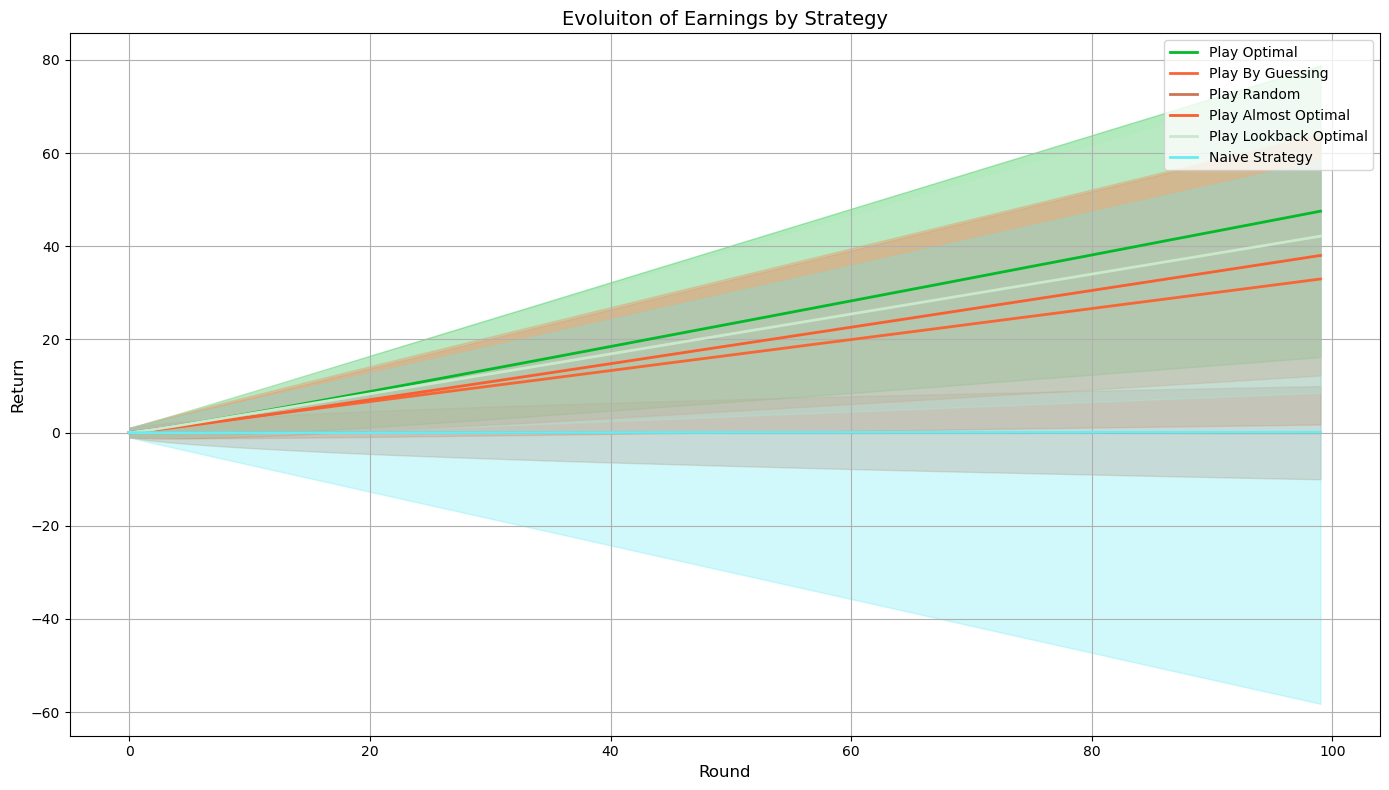

In [74]:
plt.figure(figsize=(14,8))

def plot_with_std(data, label, color):
    mean = data.cumsum(axis=1).mean(axis=0)
    std = data.cumsum(axis=1).std(axis=0)
    plt.plot(mean, linewidth=2, color=color, label=label)
    plt.fill_between(range(len(mean)), mean-std, mean+std, color=color, alpha=0.3)

for idx, strategy in enumerate(strat):
    earnings = game.calc_earnings(idx)
    plot_with_std(earnings,
                  label=strategy.replace('_', ' ').title(),
                  color="#{:06x}".format(random.randint(0, 0xFFFFFF)))

plot_with_std(naive,
                  label='Naive Strategy',
                  color="#{:06x}".format(random.randint(0, 0xFFFFFF)))
plt.title("Evoluiton of Earnings by Strategy", fontsize=14)
plt.xlabel("Round", fontsize=12)
plt.ylabel("Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

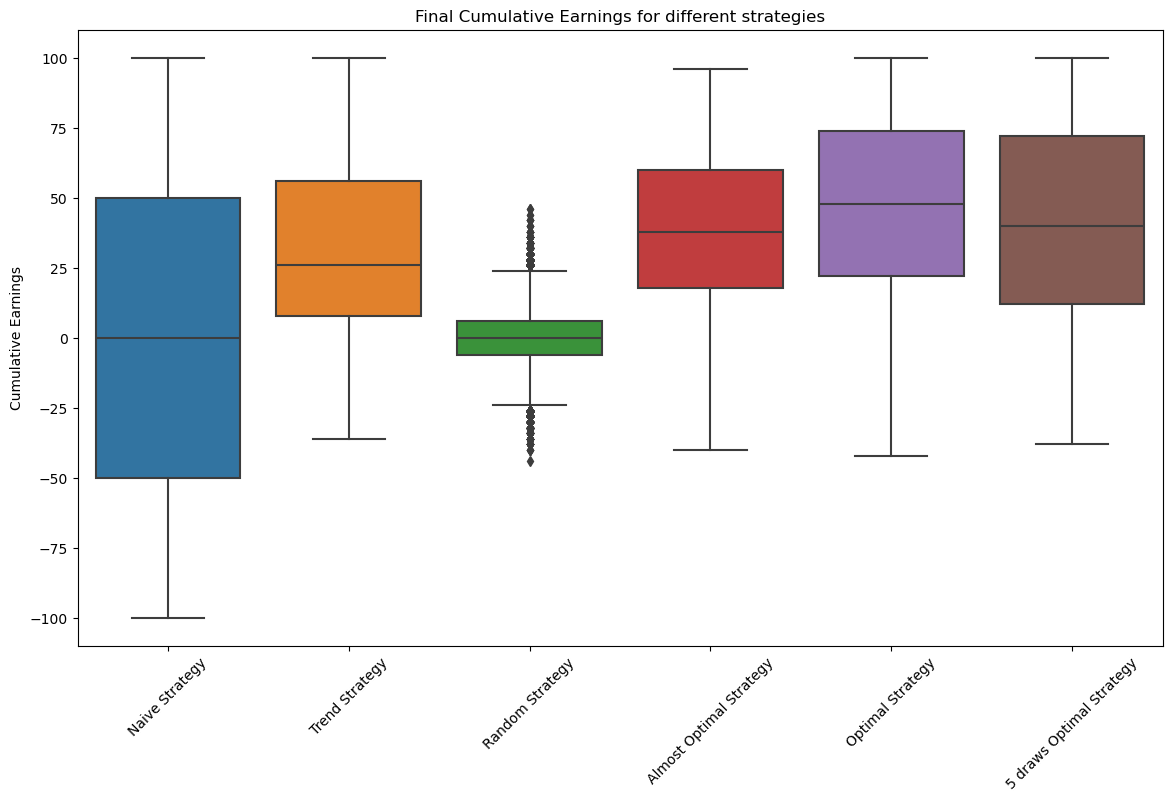

In [78]:
final_earnings = {
    "Naive Strategy": naive.cumsum(axis=1)[:, -1],
    "Trend Strategy": game.calc_earnings(1).cumsum(axis=1)[:, -1],
    "Random Strategy": game.calc_earnings(2).cumsum(axis=1)[:, -1],
    "Almost Optimal Strategy":game.calc_earnings(3).cumsum(axis=1)[:, -1],
    "Optimal Strategy": game.calc_earnings(0).cumsum(axis=1)[:, -1],
    "5 draws Optimal Strategy": game.calc_earnings(4).cumsum(axis=1)[:, -1]
}

df = pd.DataFrame(final_earnings)
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Final Cumulative Earnings for different strategies')
plt.ylabel('Cumulative Earnings')
plt.xticks(rotation=45)
plt.show()

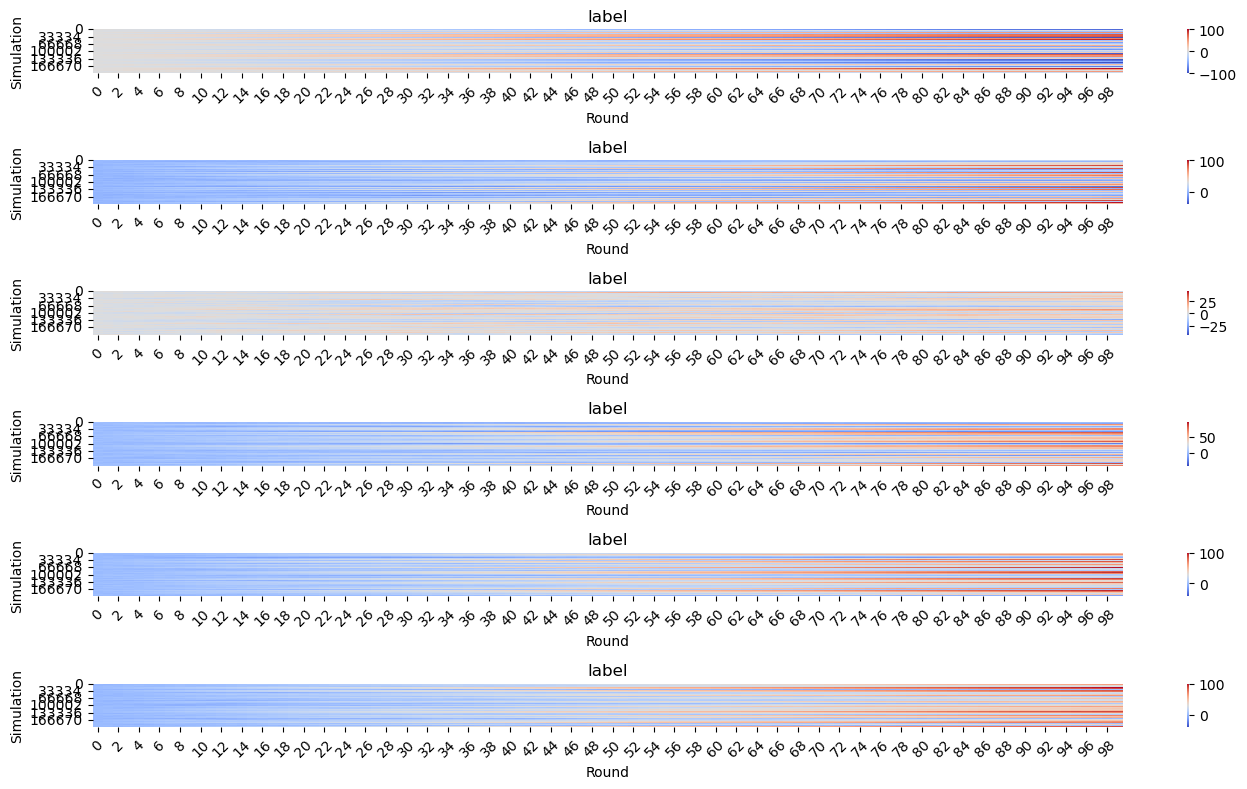

In [84]:
strategies = {
    "Naive Strategy": naive.cumsum(axis=1),
    "Trend Strategy": game.calc_earnings(1).cumsum(axis=1),
    "Random Strategy": game.calc_earnings(2).cumsum(axis=1),
    "Almost Optimal Strategy":game.calc_earnings(3).cumsum(axis=1),
    "Optimal Strategy": game.calc_earnings(0).cumsum(axis=1),
    "5 draws Optimal Strategy": game.calc_earnings(4).cumsum(axis=1)
}

df = pd.DataFrame(final_earnings)
plt.figure(figsize=(14, 8))
for i, (label, data) in enumerate(strategies.items()):
    plt.subplot(len(strategies), 1, i+1)
    sns.heatmap(data, cmap='coolwarm', cbar=True)

    plt.title('label')
    plt.ylabel('Simulation')
    plt.xlabel('Round')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A notable observation is that even the simple strategy of choosing the previous result yields some alpha compared to random allocation. This is intuitive—when the underlying probability parameter 
𝑝
p skews the distribution, the outcome from the previous round carries informative value about the next. In essence, we’re leveraging the natural imbalance in the distribution.

We proceed to quantify how much additional information this simple strategy captures

In [99]:
def study_relations(time_step, n_points=400):
    fig=plt.figure(figsize=(14, 8))
    ax=fig.add_subplot(111, projection='3d')
    random_indices = np.random.choice(len(game.ps), n_points, replace=False)

    markers = []
    alphas = []
    colors = []
    for i, p in enumerate(game.ps[random_indices]):
        if 0<=p<=0.25:
            markers.append('^')
            alphas.append(0.3+0.7*p)
        elif 0.25<= p<=0.75:
            markers.append('o')
            alphas.append(0.3+0.7*p)
        else:
            markers.append('s')
            alphas.append(0.3+0.7*p)
        diff = earnings_trend[random_indices, time_step][i]-earnings_optimal[random_indices, time_step][i]
        if diff == -2:
            colors.append('blue')
        elif diff == 0:
            if earnings_optimal[random_indices, time_step][i]==-1:
                colors.append('green')
            else:
                colors.append('orange')
        elif diff == 2:
            colors.append('red')
        else:
            raise NotImplementedError

    for i in range(len(game.ps[random_indices])):
        ax.scatter(game.ps[random_indices][i],
                   earnings_trend[random_indices, time_step][i],
                   earnings_optimal[random_indices, time_step][i],
                   color=colors[i],
                   marker=markers[i],
                   alpha=alphas[i])

# Create color legend patches
    color_legend = [
        mpatches.Patch(color='blue', label='Lost Trend / Win Optimal'),
        mpatches.Patch(color='green', label='Lost Both'),
        mpatches.Patch(color='orange', label='Win Both'),
        mpatches.Patch(color='red', label='Win Trend / Lost Optimal'),
    ]

    # Create marker legend lines
    marker_legend = [
        mlines.Line2D([], [], color='black', marker='^', linestyle='None', label='Low Strategy (p ≤ 0.25)'),
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Mid Strategy (0.25 < p ≤ 0.75)'),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', label='High Strategy (p > 0.75)'),
    ]

    # Add legends
    ax.legend(handles=color_legend + marker_legend, bbox_to_anchor=(1.2, 1), loc='best')

    # Axis labels
    ax.set_xlabel('Strategy (p)')
    ax.set_ylabel('Earnings Trend')
    ax.set_zlabel('Earnings Optimal')

    plt.show()
    

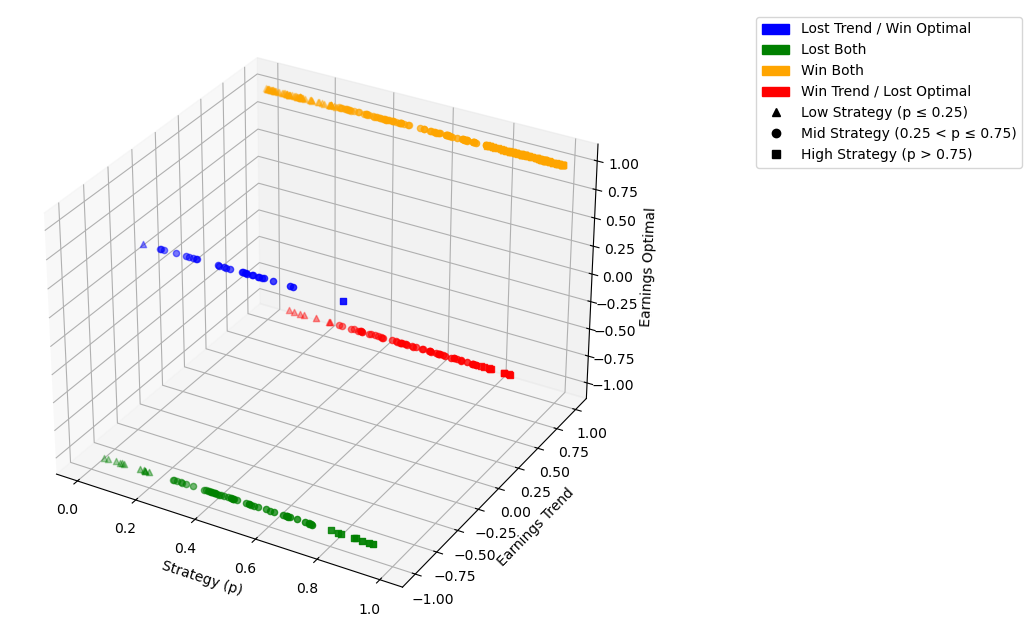

In [100]:
earnings_trend = game.calc_earnings(0)
earnings_optimal = game.calc_earnings(1)
study_relations(time_step=50, n_points=400)